# Оценка рыночной стоимости мотоцикла с пробегом

## Выполнили: Болгарин Максим, Моисеенков Павел. BD-11

<br>

**Цель проекта:** проанализировать факторы, влияющие на рыночную стоимость подержанных мотоциклов, и научиться её предсказывать. Какую пользу можно вынести из этого простому человеку? Зная, как образуется стоимость мотоцикла, владелец подобного транспортного средства может подобрать подходящую для него цену для продажи. С другой стороны, будущий владелец сможет оценить адекватность заинтересовавшего его предложения.

**План выполнения:**
1. Поиск данных, формирование датасета
    * Скачивание и парсинг данных.
    * Формирование датасета.
2. Первичный анализ данных
    * Изучение данных: определение смысла признаков, типов данных, наличия пропусков и т.д.
3. Предобработка данных
    * Очистка и отбор данных, выполнение необходимых преобразований.
4. Применение моделей анализа данных для предсказания стоимости
    * Тестирование нескольких простых моделей, сравнение качества, выбор baseline.
    * Обучение и проверка модели, показывающей наилучшее качество.
5. Вывод

<br>

### 1. Поиск данных, формирование датасета

Источником данных послужил архив объявлений на сайте moto.drom.ru

Всего было обработано около 11000 объявлений из Москвы, Санкт-Петербурга и прочих небольших городов. Скачивание производилось в [другом Jupyter Notebook](https://github.com/maxbolgarin/datamining_project/blob/master/project/parce.ipynb). На выходе мы имеем .csv файл, с ним нам и предстоит работать.

#### Подключим необходимые библиотеки

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.stats import randint

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

#### Теперь загрузим данные

In [2]:
motorcycles = pd.read_csv('data/motorcycles.csv', index_col='id')

In [3]:
motorcycles.sample(5)

,price,model,mileage,motorcycle_class,year,engine_capacity,engine_strokes,damaged,documents,city,date
id,,,,,,,,,,,
7876,210 000₽,Kawasaki er-6n,11 500 км,None,None,650 куб. см.,4х тактный,Исправен,Есть ПТС,Москва,3 августа 2012
46,70 000₽,Yamaha DT50,27 000 км,None,1996,50 куб. см.,2х тактный,Исправен,Есть ПТС,Протвино,21 ноября
5811,1 720 000₽,Yamaha V-Max 1700,4 200 км,None,2012,1 700 куб. см.,4х тактный,Исправен,Есть ПТС,Москва,13 мая 2015
714,235 000₽,Honda CBR 600F4i,32 000 км,Спортивный,2001,600 куб. см.,4х тактный,Исправен,Есть ПТС,Москва,5 мая
5652,410 000₽,Yamaha DragStar / V-Star / XVS,7 000 км,None,2012,950 куб. см.,4х тактный,Исправен,Есть ПТС,Москва,18 июня 2015


In [4]:
motorcycles.shape

(11488, 11)

Видим, что данные успешно загрузились и выглядят вполне адекватно. Можем работать дальше.

<br>

### 2. Первичный анализ данных

Посмотрим общую информацию по датасету:

In [5]:
motorcycles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11488 entries, 1 to 11783
Data columns (total 11 columns):
price               11488 non-null object
model               11488 non-null object
mileage             11488 non-null object
motorcycle_class    11488 non-null object
year                11488 non-null object
engine_capacity     11488 non-null object
engine_strokes      11488 non-null object
damaged             11488 non-null object
documents           11488 non-null object
city                11488 non-null object
date                11488 non-null object
dtypes: object(11)
memory usage: 1.1+ MB


In [6]:
motorcycles.nunique()

price               1250
model               3156
mileage             2506
motorcycle_class      16
year                  64
engine_capacity      434
engine_strokes         3
damaged                3
documents              3
city                 116
date                2518
dtype: int64

In [7]:
motorcycles.drop_duplicates().shape

(11390, 11)

Теперь подробнее рассмотрим столбцы:

**price:**

In [8]:
motorcycles.price.value_counts()

150 000₽           240
200 000₽           218
250 000₽           214
300 000₽           192
350 000₽           184
120 000₽           172
180 000₽           164
220 000₽           153
160 000₽           148
230 000₽           147
100 000₽           146
140 000₽           143
130 000₽           142
110 000₽           141
Цена не указана    134
190 000₽           134
170 000₽           130
450 000₽           126
210 000₽           119
280 000₽           118
165 000₽           117
320 000₽           111
90 000₽            110
400 000₽           108
240 000₽           102
80 000₽             96
50 000₽             95
260 000₽            94
135 000₽            90
60 000₽             88
                  ... 
536 000₽             1
1 998 000₽           1
745 000₽             1
47 960₽              1
243 500₽             1
2 145 000₽           1
1 135 000₽           1
567 000₽             1
32 900₽              1
194 900₽             1
646 000₽             1
63 200₽              1
1 294 000₽ 

**model:**

In [9]:
motorcycles.model.value_counts()[:8]

Yamaha YZF R6             162
Honda CBR 600RR           110
Honda CB 400SF            107
Suzuki Boulevard M109R    107
Kawasaki Ninja ZX-6R       91
Yamaha YZF R1              83
Yamaha FZ 6                82
Yamaha                     80
Name: model, dtype: int64

**mileage:**

In [10]:
motorcycles.mileage.value_counts()[:10] / motorcycles.mileage.size

None         0.129439
1 км         0.055710
30 000 км    0.017584
20 000 км    0.016104
25 000 км    0.013057
40 000 км    0.012013
10 000 км    0.011490
35 000 км    0.010794
15 000 км    0.010010
50 000 км    0.009749
Name: mileage, dtype: float64

**motorcycle_class:**

In [11]:
motorcycles.motorcycle_class.value_counts() / motorcycles.motorcycle_class.size

None               0.496431
Чоппер             0.181581
Классика           0.071901
Спортивный         0.062326
Спорт-турист       0.039171
Эндуро             0.034645
Круизер            0.034558
Питбайк            0.022371
Туристический      0.020717
Кроссовый          0.011316
Стритфайтер        0.010097
Кастом             0.009488
Мотард             0.002786
Трайк (трицикл)    0.001306
Детский            0.001219
Триал              0.000087
Name: motorcycle_class, dtype: float64

**year:**

In [12]:
motorcycles.year.value_counts()[:13] / motorcycles.year.size

2014    0.065721
2006    0.061368
2008    0.060498
2007    0.059018
2013    0.054840
2005    0.047180
2003    0.045526
2012    0.043698
2002    0.040477
2004    0.039432
2009    0.038997
2011    0.035864
None    0.034819
Name: year, dtype: float64

**engine_capacity:**

In [13]:
motorcycles.engine_capacity.value_counts()[:14] / motorcycles.engine_capacity.size

400 куб. см.      0.102890
600 куб. см.      0.101671
250 куб. см.      0.083565
1 000 куб. см.    0.049530
650 куб. см.      0.047615
1 300 куб. см.    0.039084
750 куб. см.      0.037169
1 200 куб. см.    0.032382
125 куб. см.      0.028987
1 800 куб. см.    0.027159
1 100 куб. см.    0.025331
800 куб. см.      0.024634
200 куб. см.      0.019760
None              0.019063
Name: engine_capacity, dtype: float64

**engine_strokes:**

In [14]:
motorcycles.engine_strokes.value_counts() / motorcycles.engine_strokes.size

4х тактный    0.841400
None          0.099843
2х тактный    0.058757
Name: engine_strokes, dtype: float64

**damaged:**

In [15]:
motorcycles.damaged.value_counts() / motorcycles.damaged.size

Исправен      0.969185
None          0.017409
Неисправен    0.013405
Name: damaged, dtype: float64

**documents:**

In [16]:
motorcycles.documents.value_counts() / motorcycles.documents.size

Есть ПТС    0.908687
Без ПТС     0.089224
None        0.002089
Name: documents, dtype: float64

**city:**

In [17]:
motorcycles.city.value_counts()[:10] / motorcycles.city.size

Москва             0.597580
Санкт-Петербург    0.270021
Серпухов           0.009053
Подольск           0.004788
Мытищи             0.004526
Одинцово           0.003743
Жуковский          0.003743
Дмитров            0.003395
Зеленоград         0.003221
Пушкино            0.003134
Name: city, dtype: float64

**date:**

In [18]:
motorcycles.sample(10).date

id
9922     5 октября 2016
3619    17 августа 2016
402             10 июля
8871            16 июля
9522    23 августа 2017
4318     13 апреля 2016
6021      20 марта 2015
5523       13 июля 2015
5819     1 октября 2015
4674    18 февраля 2016
Name: date, dtype: object

Пройдемся по столбцам и, на основе уже имеющейся информации, дадим им некоторое описание:
1. **id:** просто порядковый номер мотоцикла, который вряд ли несет какую либо полезную информацию.
2. **price:** цена мотоцикла, целевая переменная. Видим, что есть объекты со значением "Цена не указана". Их нам придется отбросить. Также можно заметить, что не у всех мотоциклов стоит адекватная цена (290₽ и т.п.). Такие объекты тоже скорее всего можно отбросить, так как они вряд ли составляют весомую долю от всех остальных. Также следует преобразовать стоимость в числовой тип, отбросив символ "₽".
3. **model:** модель мотоцикла. Можно построить отдельный столбец **manufacturer**, в котором указывать только производителя, и рассматривать его как новое свойство.
4. **mileage:** пробег мотоцикла. 13% имеют пропуски, возможно это из за того, что такие мотоциклы являются новыми. Было бы странно, если бы продавец не указывал хотя бы примерный пробег своего подержанного транспортного средства, ведь это является один из самых главных факторов при покупке. Так что заполним пропуски нулями. Также 5.6% имеют пробег "1 км", это странное значение можно тоже занулить. Значения стоит привести к числовым, отбросить подстроку "км".
5. **motorcycle_class:** класс мотоцикла. Как видим, около 50% всех объектов не имеют информции о классе. Возможно, этот столбец придется убрать из рассмотрения, так как заполнить пропуски сложно без искажения реальной информации. Считать отсутстиве значения как свойство не имеет смысла, так как класс присущ каждому мотоциклу, и отстуствие информации об этом характеризует скорее не мотоцикл, а человека, составляющего объявление.
6. **year:** год выпуска мотоцикла. Как видим, значения отсутсвуют лишь у 3.5% всех объявлений, что не значительно.
7. **engine_capacity:** объем двигателя. Пропуски имеют 2% объектов. Значения можно преобразовать с числовой тип, отбросив подстроку "куб. см.".
8. **engine_strokes:** число тактов двигателя. Видим, что всего 2 разных значения, и что больше 80% мотоциклов обладают четырехтактным двигателем. Также имеем 10% пропусков. Можно попробовать заменить пропуски на "4х тактный", так как большинство двигателей именно такие, и скорее всего продавец скорее всего знал бы, что у него особенный "2х тактный" двигатель, и указал бы это. Не думаю, что ошибка будет более 1% от общего количества. Также обрежем строку до одного числа, 2 или 4.
9. **damaged:** состояние мотоцикла. Пропуски имеют 2%, и с большой уверенностью можно заполнить их значениями "Исправен", так как предполагается, что если мотоцикл сломан, то продавец об этом скорее всего сообщит заранее (если он добросовестный, конечно). Также значение "Исправен" можно закодировать под 0, а "Неисправен" - под 1.
10. **documents:** наличие ПТС у продавца. Аналогично с прошлым столбцом, можно заполнить пропуски самым популярным вариантом и закодировать "Есть ПТС" как 0 и "Без ПТС" как 1.
11. **city:** город, в котором продается мотоцикл. Пропусков нет.
12. **date:** как можно заметить из семпла, у некоторых объявлений есть информация о годе, а у некоторых нет. Те, у которых нет - объявления за 2018 год. Надо подправить это и дописать 2018 к этим датам.

<br>

### 3. Предобработка данных

Для начала избавимся от повторяющихся значений и запомним изначальное число объявлений:

In [19]:
motorcycles = motorcycles.drop_duplicates()
number_of_motocycles = motorcycles.shape[0]

Напишем функцию drop_none для упрощения работы:

In [20]:
def drop_none(df):
    return df.replace(to_replace='None', value=np.nan).dropna()

Теперь произведем обработку слобцов в соответствии с замечаниями, данными выше.

Начнем с преобразования целевого столбца **price**:

In [21]:
motorcycles.price = drop_none(motorcycles.price)
motorcycles = motorcycles[motorcycles.price != "Цена не указана"]
motorcycles.price = motorcycles.price.str[:-1].replace(' ', '', regex=True).astype(np.int64)
motorcycles.price = motorcycles.loc[motorcycles.price.values > 4999, 'price']
motorcycles.price = motorcycles.loc[motorcycles.price.values < 10000001, 'price']

/Users/P_Moiseenkov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


Перейдем к столбцу **model**:

In [22]:
(motorcycles.model.shape[0] - drop_none(motorcycles.model).shape[0]) / motorcycles.model.shape[0]

0.0010660033756773562

Как видим, None имеют один процент мотоциклов, поэтому отбросим их и создадим новый столбец **manufacturer**:

In [23]:
motorcycles.model = drop_none(motorcycles.model)
motorcycles['manufacturer'] = [item[0] if type(item) is list else item
                               for item in motorcycles.model.str.split(' ').values]

Преобразуем столбец **mileage**:

In [24]:
motorcycles.mileage = motorcycles.mileage.str.replace("None", "0")
motorcycles.mileage = motorcycles.mileage.str.replace("1 км", "0", regex=True)
motorcycles.mileage = motorcycles.mileage.str.replace("км", "", regex=True)
motorcycles.mileage = motorcycles.mileage.str.replace(' ', '', regex=True).astype(np.int64)

Как решили ранее, с **motorcycle_class** работать сложно, поэтому просто не будем рассматривать этот столбец.

In [25]:
motorcycles = motorcycles.drop(['motorcycle_class'], axis=1)

Отбросим пропуски и преобразуем тип значений столбца **year** в integer:

In [26]:
motorcycles.year = drop_none(motorcycles.year)
motorcycles.year = motorcycles.year.dropna().astype(np.int32)

На очереди **engine_capacity**:

In [27]:
motorcycles.engine_capacity = drop_none(motorcycles.engine_capacity)
motorcycles.engine_capacity = motorcycles.engine_capacity.str.replace("куб. см.", '', regex=True)
motorcycles.engine_capacity = motorcycles.engine_capacity.str.replace(' ', '', regex=True)
motorcycles.engine_capacity = motorcycles.engine_capacity.dropna().astype(np.int64)

В столбце **engine_strokes** заменим None на "4х тактный":

In [28]:
motorcycles.engine_strokes = motorcycles.engine_strokes.str.replace("None", "4", regex=True)
motorcycles.engine_strokes = motorcycles.engine_strokes.str.replace("х тактный", '', regex=True)
motorcycles.engine_strokes = motorcycles.engine_strokes.dropna().astype(np.int64)

Преобразуем **damaged**:

In [29]:
motorcycles.damaged = motorcycles.damaged.str.replace("None", "0", regex=True)
motorcycles.damaged = motorcycles.damaged.str.replace("Исправен", "0", regex=True)
motorcycles.damaged = motorcycles.damaged.str.replace("Неисправен", "1", regex=True)
motorcycles.damaged = motorcycles.damaged.dropna().astype(np.int64)

Аналогично **documents**:

In [30]:
motorcycles.documents = motorcycles.documents.str.replace("None", "0", regex=True)
motorcycles.documents = motorcycles.documents.str.replace("Есть ПТС", "0", regex=True)
motorcycles.documents = motorcycles.documents.str.replace("Без ПТС", "1", regex=True)
motorcycles.documents = motorcycles.documents.dropna().astype(np.int64)

Наконец, преобразуем столбец **date**. Сначала добавим год тем объектам, у которых его нет:

In [31]:
motorcycles.date = [s + " 2018" if len(s.split()) == 2 else s for s in motorcycles.date.values]

По хорошему, строки с датой надо бы привести к формату datetime. Однако, не совсем понятно, как работать с названиями месяцев на русском языке. Поэтому поменяем их на английский, а потом приведем значения к datetime:

In [32]:
rus_eng_month = {
    'января': 'January',
    'февраля': 'February',
    'марта': 'March',
    'апреля': 'April',
    'мая': 'May',
    'июня': 'June',
    'июля': 'July',
    'августа': 'August',
    'сентября': 'September',
    'октября': 'October',
    'ноября': 'November',
    'декабря': 'December',  
}

dates = []
for s in motorcycles.date.values:
    temp_s = s.split()
    dates.append(temp_s[0] + ' ' + rus_eng_month[temp_s[1]] + ' ' + temp_s[2])
    
motorcycles.date = [datetime.strptime(s, '%d %B %Y').strftime('%Y-%m-%d') for s in dates]
motorcycles.date = pd.to_datetime(motorcycles.date.dropna()).dt.date

Отбросим оставшиеся неопределенные значения:

In [33]:
motorcycles = drop_none(motorcycles)
motorcycles = motorcycles.dropna()

Вот так теперь выглядит таблица:

In [34]:
motorcycles.sample(5)

,price,model,mileage,year,engine_capacity,engine_strokes,damaged,documents,city,date,manufacturer
id,,,,,,,,,,,
8308,100000.0,GSX-R400,32720,1992.0,400.0,4,0,0,Подольск,2010-03-11,GSX-R400
2174,253000.0,BMW F 650 GS,44989,2002.0,650.0,4,0,0,Москва,2017-05-08,BMW
3076,599000.0,BRP Can-Am Spyder RS SE5,7000,2010.0,990.0,4,0,0,Москва,2016-11-03,BRP
11742,220000.0,VN 800 Drifter,10000,2002.0,800.0,4,0,0,Санкт-Петербург,2009-08-24,VN
8925,382000.0,Yamaha FZ 1,22000,2008.0,1000.0,4,0,0,Санкт-Петербург,2018-07-16,Yamaha


In [35]:
motorcycles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10718 entries, 1 to 11783
Data columns (total 11 columns):
price              10718 non-null float64
model              10718 non-null object
mileage            10718 non-null int64
year               10718 non-null float64
engine_capacity    10718 non-null float64
engine_strokes     10718 non-null int64
damaged            10718 non-null int64
documents          10718 non-null int64
city               10718 non-null object
date               10718 non-null object
manufacturer       10718 non-null object
dtypes: float64(3), int64(4), object(4)
memory usage: 1004.8+ KB


Посмотрим, сколько осталось объектов после всех преобразований:

In [36]:
print('Было: {}'.format(number_of_motocycles))
print('Осталось: {}'.format(motorcycles.shape[0]))
print('Датасет уменьшился на {:.3}% от первоначального размера'.format(
    100*(number_of_motocycles - motorcycles.shape[0]) / number_of_motocycles)
     )

Было: 11390
Осталось: 10718
Датасет уменьшился на 5.9% от первоначального размера


Как видим, после данных преобразований датасет уменьшился незначительно. Теперь обратим внимание на стобец **manufacturer**.

In [37]:
motorcycles.manufacturer.value_counts()

Honda              2483
Yamaha             1873
Suzuki             1379
Kawasaki           1016
BMW                 436
Harley-Davidson     412
KTM                 196
Ducati              164
Irbis               121
Stels               119
HONDA               101
Racer                87
Kayo                 87
YAMAHA               86
Triumph              79
Урал                 74
Aprilia              67
Baltmotors           52
Иж                   47
Ява                  45
SUZUKI               36
BSE                  35
Victory              33
Sym                  31
NO.                  28
Минск                28
Днепр                27
ABM                  26
CBR                  22
Wels                 21
                   ... 
XVS                   1
FXDB103               1
YCF-50A               1
HAYABUSA              1
Полноприводный        1
GR                    1
rf400                 1
Реплика               1
Wite                  1
electra               1
SUPERDUKE       

Как можно заметить, встречаются одинаковые названия производителей, но написанные разным способом. Компьютер их различает как разных производителей, нам же надо преобразовать их к одному единому виду.

Если "NO.", то название производителя начинается с третьего слова в **model**:

In [38]:
motorcycles.loc[motorcycles.manufacturer == "NO.", "manufacturer"] = \
            [item[2] for item in motorcycles[motorcycles.manufacturer == "NO."].model.str.split().values]

Honda $\leftarrow$ HONDA, honda, ХОНДА, Хонда, CBR, CB, CB400

In [39]:
motorcycles.manufacturer = motorcycles.manufacturer.str.replace("HONDA", "Honda", regex=True)
motorcycles.manufacturer = motorcycles.manufacturer.str.replace("ХОНДА", "Honda", regex=True)
motorcycles.manufacturer = motorcycles.manufacturer.str.replace("Хонда", "Honda", regex=True)
motorcycles.manufacturer = motorcycles.manufacturer.str.replace("honda", "Honda", regex=True)
motorcycles.loc[motorcycles.manufacturer == "CBR", "manufacturer"] = "Honda"
motorcycles.loc[motorcycles.manufacturer == "CB", "manufacturer"] = "Honda"
motorcycles.loc[motorcycles.manufacturer == "CB400", "manufacturer"] = "Honda"
motorcycles.manufacturer = motorcycles.manufacturer.str.replace("CBR", "Honda", regex=True)
motorcycles.manufacturer = motorcycles.manufacturer.str.replace("CB", "Honda", regex=True)
motorcycles.manufacturer = motorcycles.manufacturer.str.replace("CB400", "Honda", regex=True)

Yamaha $\leftarrow$ YAMAHA, yamaha

In [40]:
motorcycles.manufacturer = motorcycles.manufacturer.str.replace("YAMAHA", "Yamaha", regex=True)
motorcycles.manufacturer = motorcycles.manufacturer.str.replace("yamaha", "Yamaha", regex=True)

Harley-Davidson $\leftarrow$ Harleu-Davidson, HARLEY-DAVIDSON, Харли, Harley, Harley-Davidson, Harley-Davidson

In [41]:
motorcycles.manufacturer = motorcycles.manufacturer.str.replace("Harleu-Davidson", "Harley-Davidson", regex=True)
motorcycles.manufacturer = motorcycles.manufacturer.str.replace("HARLEY-DAVIDSON", "Harley-Davidson", regex=True)
motorcycles.manufacturer = motorcycles.manufacturer.str.replace("Харли", "Harley-Davidson", regex=True)
motorcycles.manufacturer = motorcycles.manufacturer.str.replace("Harley-Davidson", "Harley-Davidson", regex=True)
motorcycles.loc[motorcycles.manufacturer == "Harley", "manufacturer"] = "Harley-Davidson"

Kawasaki $\leftarrow$ KAWASAKI, КАВАСАКИ, Кавасаки, кавасаки, kawasaki

In [42]:
motorcycles.manufacturer = motorcycles.manufacturer.str.replace("KAWASAKI", "Kawasaki", regex=True)
motorcycles.manufacturer = motorcycles.manufacturer.str.replace("КАВАСАКИ", "Kawasaki", regex=True)
motorcycles.manufacturer = motorcycles.manufacturer.str.replace("Кавасаки", "Kawasaki", regex=True)
motorcycles.manufacturer = motorcycles.manufacturer.str.replace("кавасаки", "Kawasaki", regex=True)
motorcycles.manufacturer = motorcycles.manufacturer.str.replace("kawasaki", "Kawasaki", regex=True)

Suzuki $\leftarrow$ сузуки, suzuki, SUZUKI, Сузуки

In [43]:
motorcycles.manufacturer = motorcycles.manufacturer.str.replace("сузуки", "Suzuki", regex=True)
motorcycles.manufacturer = motorcycles.manufacturer.str.replace("suzuki", "Suzuki", regex=True)
motorcycles.manufacturer = motorcycles.manufacturer.str.replace("Сузуки", "Suzuki", regex=True)
motorcycles.manufacturer = motorcycles.manufacturer.str.replace("SUZUKI", "Suzuki", regex=True)

Ява $\leftarrow$ ЯВА

In [44]:
motorcycles.manufacturer = motorcycles.manufacturer.str.replace("ЯВА", "Ява", regex=True)

Иж $\leftarrow$ ИЖ, иж, ИЖ-49, Иж-49

In [45]:
motorcycles.manufacturer = motorcycles.manufacturer.str.replace("ИЖ", "Иж", regex=True)
motorcycles.manufacturer = motorcycles.manufacturer.str.replace("иж", "Иж", regex=True)
motorcycles.manufacturer = motorcycles.manufacturer.str.replace("ИЖ-49", "Иж", regex=True)
motorcycles.manufacturer = motorcycles.manufacturer.str.replace("Иж-49", "Иж", regex=True)

Triumph $\leftarrow$ triumph, TRIUMPH

In [46]:
motorcycles.manufacturer = motorcycles.manufacturer.str.replace("triumph", "Triumph", regex=True)
motorcycles.manufacturer = motorcycles.manufacturer.str.replace("TRIUMPH", "Triumph", regex=True)

Ducati $\leftarrow$ DUCATI

In [47]:
motorcycles.manufacturer = motorcycles.manufacturer.str.replace("DUCATI", "Ducati", regex=True)

Теперь самым редким производителям дадим метку Other:

In [48]:
names = [motorcycles.manufacturer.value_counts().index[i] 
         if m < 30 else None for i, m in enumerate(motorcycles.manufacturer.value_counts())]
names = np.array(names)
names = names[names != np.array(None)]

for moto in motorcycles.manufacturer.values:
    if moto in names:
        motorcycles.loc[motorcycles.manufacturer == moto, "manufacturer"] = "Other"
        
motorcycles.manufacturer.value_counts()

Honda              2655
Yamaha             1971
Other              1516
Suzuki             1419
Kawasaki           1031
BMW                 442
Harley-Davidson     420
KTM                 196
Ducati              168
Irbis               121
Stels               119
Triumph              93
Racer                87
Kayo                 87
Урал                 74
Aprilia              67
Иж                   54
Baltmotors           52
Ява                  47
BSE                  35
Victory              33
Sym                  31
Name: manufacturer, dtype: int64

Теперь у нас есть неплохая информация о производителях. Можно отбросить столбец с моделями, так как нам не нужна излишняя информация:

In [49]:
motorcycles = motorcycles.drop(["model"], axis=1)

Осталось сделать некоторые преобразования со столбцом **city**:

In [50]:
cities = [motorcycles.city.value_counts().index[i] 
         if m < 30 else None for i, m in enumerate(motorcycles.city.value_counts())]

cities = np.array(cities)
cities = cities[cities != np.array(None)]

for city in motorcycles.city.values:
    if city in cities:
        motorcycles.loc[motorcycles.city == city, "city"] = "Другой"
        
motorcycles.city.value_counts()

Москва             6353
Санкт-Петербург    2956
Другой              832
Серпухов            101
Подольск             52
Мытищи               47
Жуковский            42
Одинцово             40
Егорьевск            36
Дмитров              36
Пушкино              35
Зеленоград           34
Ногинск              32
Коломна              32
Домодедово           30
Щелково              30
Раменское            30
Name: city, dtype: int64

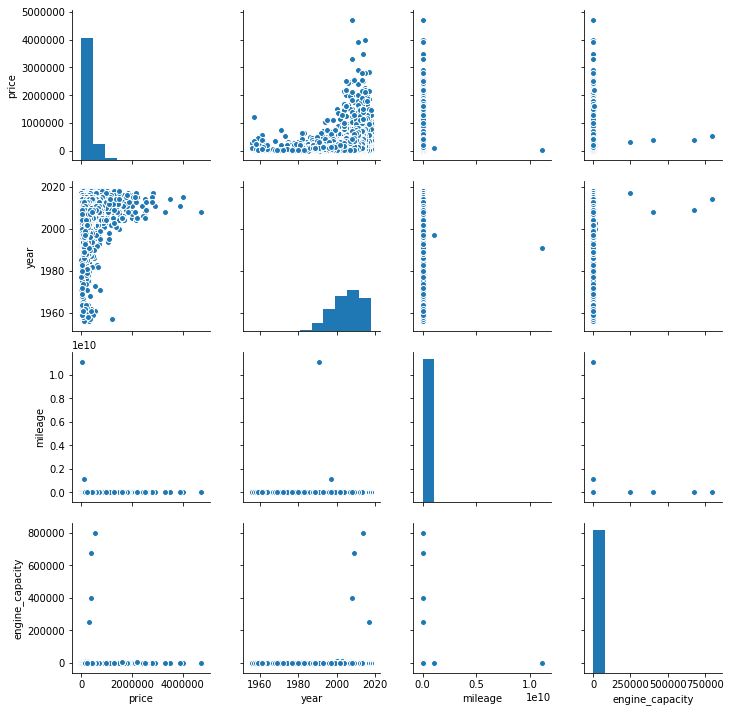

In [52]:
import seaborn as sns
cols = ['price', 'year',  'mileage',
       'engine_capacity']
sns_plot = sns.pairplot(motorcycles[cols].dropna())  

Предварительная обработка данных закончена. Теперь можем приступать к анализу датасета и построению моделей.

<br>

### 4. Применение моделей анализа данных для предсказания стоимости

Перед использованием данных в модели необходимо закодировать категориальные переменные. Для этого используем одход one-hot encoding. Для избежания эффекта мультиколлинеарности выкинем самое популярное значение (мы можем закодировать g вариантов g-1 one-hot признаками без потери информации):

In [51]:
motorcycles = pd.concat([motorcycles,
                         pd.get_dummies(motorcycles.loc[motorcycles.manufacturer != 'Honda', 
                                                        'manufacturer'])], axis=1)

motorcycles = pd.concat([motorcycles,
                         pd.get_dummies(motorcycles.loc[motorcycles.city != 'Москва', 
                                                        'city'])], axis=1)

motorcycles = motorcycles.drop(['manufacturer'], axis=1)
motorcycles = motorcycles.drop(['city'], axis=1)
motorcycles = motorcycles.fillna(value=0)

Также необходимо преобразовать дату. В качестве baseline даты выберем саммую раннюю в датасете, и от нее будет отсчитывать число прошедших дней.

In [52]:
baseline_date = motorcycles.tail(1).date.values
date_code = []
for date in motorcycles.date.values:
    date_code.append((date - baseline_date)[0].days)
    
motorcycles['date_code'] = date_code
motorcycles = motorcycles.drop(['date'], axis=1)

Теперь датасет готов для применения в моделях. Разобъем его на обучающую и тестовую выборки:

In [53]:
X_train, X_test, y_train, y_test = train_test_split(motorcycles.drop(['price'], axis=1), 
                                                    motorcycles.price, test_size=0.25, 
                                                    random_state=42)

Стандартизуем:

In [54]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Определим две функции для вычисления качества модели. Первая будет просто рассчитывать RMSE, вторая же - проводить кросс-валидацию. Так как мы решаем задачу регрессии, то в качестве метрики качества для кросс валидации будет использоваться коэффициент детерминации ($R^2$ score).

Пара слов об $R^2$ score. Для приемлемых моделей предполагается, что коэффициент детерминации должен быть хотя бы не меньше 50 % (в этом случае коэффициент множественной корреляции превышает по модулю 70 %). Модели с коэффициентом детерминации выше 80 % можно признать достаточно хорошими (коэффициент корреляции превышает 90 %). Значение коэффициента детерминации 1 означает функциональную зависимость между переменными. В общем случае коэффициент детерминации может быть и отрицательным, это говорит о крайней неадекватности модели: простое среднее приближает лучше.

$$ R^2 = 1 - \frac{\sum_{i=1}^{n}(y_i - \hat{y_i})^2}{\sum_{i=1}^{n}(y_i - \bar{y_i})^2} = 1 - \frac{\sum_{i=1}^{n}(y_i - \hat{y_i})^2}{n\hat{\sigma_y}^2}, \:\: \bar{y} = \frac{1}{n}\sum_{i=1}^n y_i $$

In [55]:
def test_model(model, X_train, y_train, X_test=None, y_test=None, model_name=''):
    model.fit(X_train, y_train)
    prediction = model.predict(X_train)
    rmse = np.sqrt(mean_squared_error(y_train, prediction))
    print("{} train RMSE: {:.3f}".format(model_name, rmse))
    
    if X_test is not None and y_test is not None:
        prediction_test = model.predict(X_test)
        rmse_test = np.sqrt(mean_squared_error(y_test, prediction_test))
        print("{} test RMSE: {:.3f}".format(model_name, rmse_test))

In [56]:
def model_score(model, X_train, y_train, cv=5, model_name='', scoring='r2'):
    scores = cross_val_score(model, X_train, y=y_train, cv=cv, scoring=scoring)
    print("{} {} score: {:.2f} (+/- {:.2f})".format(model_name, scoring, scores.mean(), scores.std()*2))

Попробуем разные модели для решения задач регрессии. Использовать будем готовые реализации из библиотеки sklearn.

**K-ближайших соседей**:

In [57]:
model_knn = KNeighborsRegressor()

test_model(model_knn, X_train_scaled, y_train, X_test_scaled, y_test, model_name='kNN')
model_score(model_knn, X_train_scaled, y_train, model_name='kNN')

kNN train RMSE: 158949.680
kNN test RMSE: 193216.615
kNN r2 score: 0.47 (+/- 0.08)


**Линейная регрессия**:

In [58]:
model_linear = LinearRegression()

test_model(model_linear, X_train_scaled, y_train, X_test_scaled, y_test, model_name='Linear')
model_score(model_linear, X_train_scaled, y_train, model_name='Linear')

Linear train RMSE: 218503.426
Linear test RMSE: 221092.340
Linear r2 score: 0.37 (+/- 0.07)


**Дерево решений**:

In [59]:
model_tree = DecisionTreeRegressor(max_depth=10)

test_model(model_tree, X_train, y_train, X_test, y_test, model_name='Tree')
model_score(model_tree, X_train, y_train, model_name='Tree')

Tree train RMSE: 86558.139
Tree test RMSE: 190568.452
Tree r2 score: 0.54 (+/- 0.27)


**Случайный лес**:

In [60]:
model_forest = RandomForestRegressor()

test_model(model_forest, X_train, y_train, X_test, y_test, model_name='Forest')
model_score(model_forest, X_train, y_train, model_name='Forest')

Forest train RMSE: 59599.522
Forest test RMSE: 157684.501
Forest r2 score: 0.71 (+/- 0.10)


Как видим, наилучший результат показал случайный лес (что вполне логично), поэтому в качестве рабочей модели будем использовать именно его.

Для того, чтобы добиться наилучшего результата, необходимо провести подбор оптимальных гиперпараметров модели. Для этого будем использовать случайный поиск:

In [61]:
param_grid = {
    'n_estimators': randint(10, 100),
    'criterion': ['mse', 'mae'],
    'max_depth': randint(6, 20) }

n_iter = 200

model = RandomForestRegressor()
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=n_iter,
                                   n_jobs=2, cv=5, scoring='r2')
random_search = random_search.fit(X_train, y_train)

Наилучшие параметры:

In [62]:
random_search.best_params_

{'criterion': 'mae', 'max_depth': 17, 'n_estimators': 55}

Наилучший достигнутый score:

In [63]:
random_search.best_score_

0.7429804520310012

Выберем модель с наилучшими параметрами:

In [64]:
best_model = random_search.best_estimator_

Теперь проверим модель на тестовой выборке:

In [65]:
prediction = best_model.predict(X_test)
score = r2_score(y_test, prediction)
print("Best model r2 score: {:.3}".format(score))

Best model r2 score: 0.704


Таким образом, наша модель оценивает цену подержанных мотоциклов плохо, однако лучше рандома.

<br>

### 5. Вывод

Цель работы заключалась в оценке рыночной стоимости мотоцикла с пробегом.

В ходе выполнения работы сделано:
1. Получены данные о продаже более 11000 мотоциклов в Москве, Санкт-Петербурге и других городах
2. Данные обработанны и подготовленны для анализа с использованием различных моделей
3. Выбрана модель (случайный лес) и метрика качества (коэффициент детерминации)
4. Произведен подбор гиперпараметров
5. Тестрирование модели на выборке, неизвестной на этапе обучения

По результатам тестирования получаем следующее значение коэффициента детерминации: 0.70

Подводя итоги можно сказать, что качество модели оставляет желать лучшего. Возможно, это вызвано ошибками при подготовке данных, а также недостаточно качественным и полным подбором гиперпараметров.